In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB, MultinomialNB
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler

In [38]:
data = pd.read_csv(r"C:\Users\HP\Desktop\MACHINE LEARNING\heartdataset.csv")


----- Dataset Info -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             700 non-null    int64  
 1   Sex             700 non-null    object 
 2   ChestPainType   700 non-null    object 
 3   RestingBP       700 non-null    int64  
 4   Cholesterol     700 non-null    int64  
 5   FastingBS       700 non-null    int64  
 6   RestingECG      700 non-null    object 
 7   MaxHR           700 non-null    int64  
 8   ExerciseAngina  700 non-null    object 
 9   Oldpeak         700 non-null    float64
 10  ST_Slope        700 non-null    object 
 11  HeartDisease    700 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 65.8+ KB
None

----- Descriptive Statistics -----
              Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  700.000000  700.000000   700.000000  700.000000  700.00000

C:\Users\HP\AppData\Local\Temp\ipykernel_16532\811057546.py:18: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap='coolwarm')


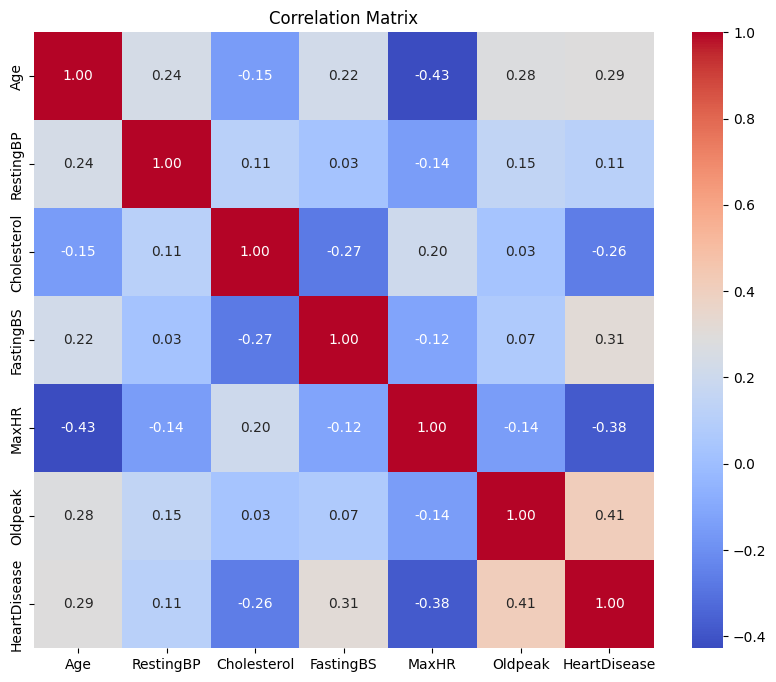


----- Feature Distribution -----


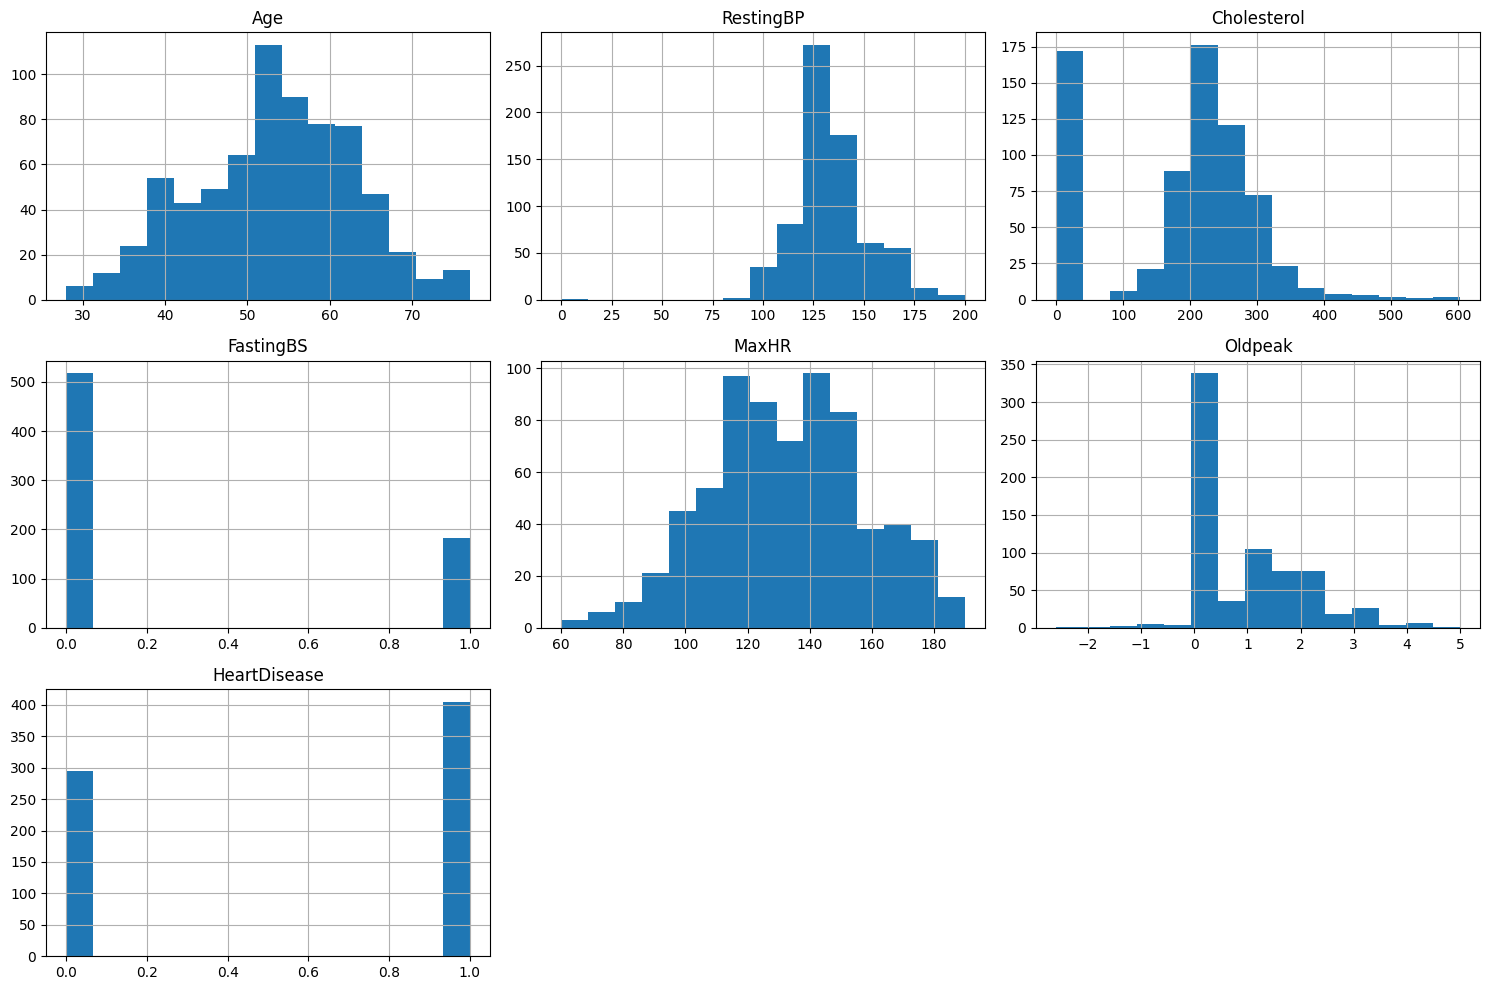

In [39]:
# 1. Detailed EDA (Exploratory Data Analysis)
def perform_eda(data):
    print("\n----- Dataset Info -----")
    print(data.info())
    
    print("\n----- Descriptive Statistics -----")
    print(data.describe())
    
    print("\n----- Missing Values -----")
    print(data.isnull().sum())

    print("\n----- Class Distribution -----")
    if 'target' in data.columns:
        print(data['target'].value_counts())
    
    print("\n----- Correlation Matrix -----")
    plt.figure(figsize=(10, 8))
    sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap='coolwarm')
    plt.title("Correlation Matrix")
    plt.show()
    
    print("\n----- Feature Distribution -----")
    data.hist(bins=15, figsize=(15, 10))
    plt.tight_layout()
    plt.show()

perform_eda(data)

In [40]:
# Encode categorical columns
def encode_data(data):
    for column in data.columns:
        if data[column].dtype == 'object':
            if data[column].nunique() <= 10:  # For nominal categorical data
                data = pd.get_dummies(data, columns=[column], drop_first=True)
            else:  # For ordinal categorical data
                le = LabelEncoder()
                data[column] = le.fit_transform(data[column])
    return data

data = encode_data(data)


In [41]:
# Prepare the dataset 
if 'HeartDisease' in data.columns:
    X = data.drop(columns=['HeartDisease'])
    y = data['HeartDisease']
else:
    raise KeyError("The dataset does not contain a 'HeartDisease' column.")

# Scale features for MultinomialNB compatibility
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [42]:
# 2. Train Gaussian Naive Bayes classifier
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)

# Accuracy score for GaussianNB
acc_gnb = accuracy_score(y_test, y_pred_gnb)
print(f"Gaussian Naive Bayes Accuracy: {acc_gnb:.2f}")

Gaussian Naive Bayes Accuracy: 0.93


In [43]:
# 3. Train Multinomial Naive Bayes classifier
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_pred_mnb = mnb.predict(X_test)

# Accuracy score for MultinomialNB
acc_mnb = accuracy_score(y_test, y_pred_mnb)
print(f"Multinomial Naive Bayes Accuracy: {acc_mnb:.2f}")

Multinomial Naive Bayes Accuracy: 0.90


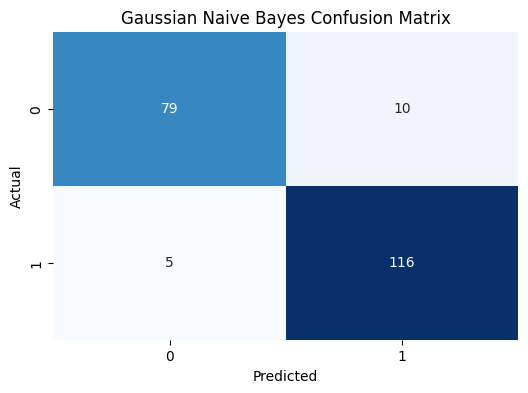

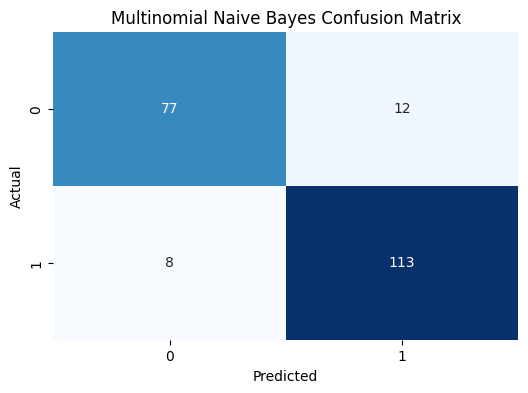

Gaussian Naive Bayes CV Accuracy: 0.87
Multinomial Naive Bayes CV Accuracy: 0.86


In [44]:
# 4. Confusion Matrix with Cross-Validation
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(y_test, y_pred_gnb, "Gaussian Naive Bayes Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_mnb, "Multinomial Naive Bayes Confusion Matrix")

# Scale X to be non-negative for MultinomialNB
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Cross-validation with scaled data for MultinomialNB
cv_gnb = cross_val_score(gnb, X, y, cv=10, scoring='accuracy').mean()
cv_mnb = cross_val_score(mnb, X_scaled, y, cv=10, scoring='accuracy').mean()

print(f"Gaussian Naive Bayes CV Accuracy: {cv_gnb:.2f}")
print(f"Multinomial Naive Bayes CV Accuracy: {cv_mnb:.2f}")


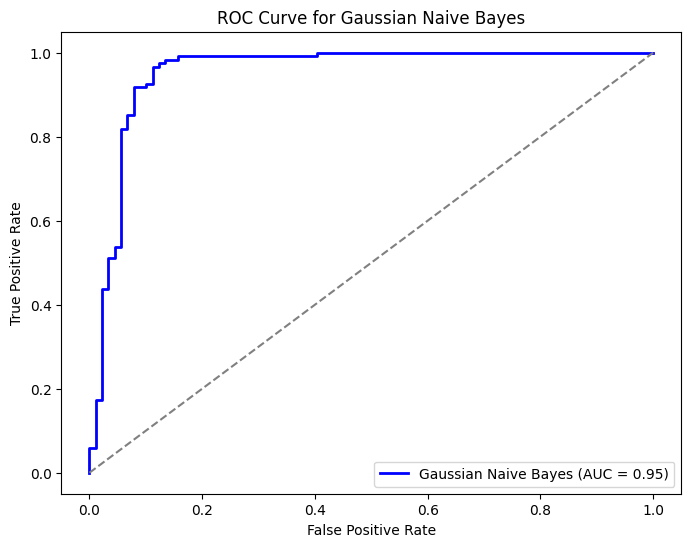

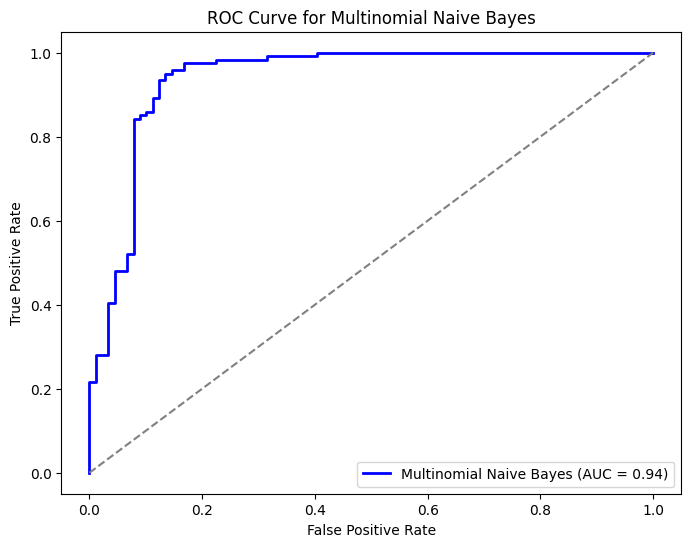

In [45]:
# 5. ROC Curves (Applicable only for binary classification)
def plot_roc_curve(clf, X_test, y_test, clf_name):
    if hasattr(clf, 'predict_proba'):
        y_proba = clf.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'{clf_name} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f"ROC Curve for {clf_name}")
        plt.legend(loc='lower right')
        plt.show()

plot_roc_curve(gnb, X_test, y_test, "Gaussian Naive Bayes")
plot_roc_curve(mnb, X_test, y_test, "Multinomial Naive Bayes")

In [46]:
#Gaussian Naive Bayes performed  with an accuracy of 0.93
#Multinomial Naive Bayes performed  with an accuracy of 0.90

#Cross-validation confirms the overall trends in classifier performance
#The ROC curves indicate the capability of classifiers to distinguish between the classes. Consider choosing a model based on specific needs and data distribution
